In [1]:
!pip install --upgrade quantecon

In [2]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt

In [3]:
class ConsumptionProblem:
    """
    The data for a consumption problem, including some default values.
    """

    def __init__(self,
                 β=.96,
                 y=[2, 1.5],
                 b0=3,
                 P=[[.8, .2],
                    [.4, .6]],
                 init=0):
        """
        Parameters
        ----------

        β : discount factor
        y : list containing the two income levels
        b0 : debt in period 0 (= initial state debt level)
        P : 2x2 transition matrix
        init : index of initial state s0
        """
        self.β = β
        self.y = np.asarray(y)
        self.b0 = b0
        self.P = np.asarray(P)
        self.init = init

    def simulate(self, N_simul=80, random_state=1):
        """
        Parameters
        ----------

        N_simul : number of periods for simulation
        random_state : random state for simulating Markov chain
        """
        # For the simulation define a quantecon MC class
        mc = qe.MarkovChain(self.P)
        s_path = mc.simulate(N_simul, init=self.init, random_state=random_state)

        return s_path


def consumption_complete(cp):
    """
    Computes endogenous values for the complete market case.

    Parameters
    ----------

    cp : instance of ConsumptionProblem

    Returns
    -------

        c_bar : constant consumption
        b : optimal debt in each state

    associated with the price system

        Q = β * P
    """
    β, P, y, b0, init = cp.β, cp.P, cp.y, cp.b0, cp.init   # Unpack

    Q = β * P                               # assumed price system

    # construct matrices of augmented equation system
    n = P.shape[0] + 1

    y_aug = np.empty((n, 1))
    y_aug[0, 0] = y[init] - b0
    y_aug[1:, 0] = y

    Q_aug = np.zeros((n, n))
    Q_aug[0, 1:] = Q[init, :]
    Q_aug[1:, 1:] = Q

    A = np.zeros((n, n))
    A[:, 0] = 1
    A[1:, 1:] = np.eye(n-1)

    x = np.linalg.inv(A - Q_aug) @ y_aug

    c_bar = x[0, 0]
    b = x[1:, 0]

    return c_bar, b


def consumption_incomplete(cp, s_path):
    """
    Computes endogenous values for the incomplete market case.

    Parameters
    ----------

    cp : instance of ConsumptionProblem
    s_path : the path of states
    """
    β, P, y, b0 = cp.β, cp.P, cp.y, cp.b0  # Unpack

    N_simul = len(s_path)

    # Useful variables
    n = len(y)
    y.shape = (n, 1)
    v = np.linalg.inv(np.eye(n) - β * P) @ y

    # Store consumption and debt path
    b_path, c_path = np.ones(N_simul+1), np.ones(N_simul)
    b_path[0] = b0

    # Optimal decisions from (12) and (13)
    db = ((1 - β) * v - y) / β

    for i, s in enumerate(s_path):
        c_path[i] = (1 - β) * (v - np.full((n, 1), b_path[i]))[s, 0]
        b_path[i + 1] = b_path[i] + db[s, 0]

    return c_path, b_path[:-1], y[s_path]

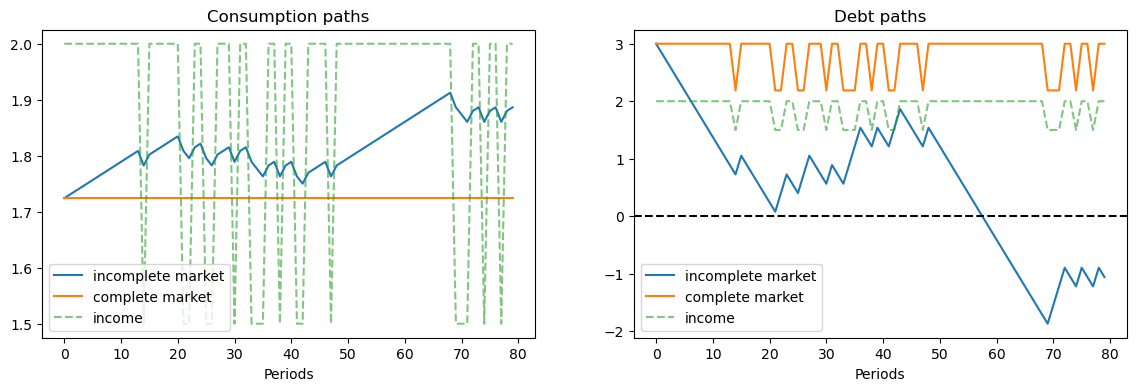

In [4]:
cp = ConsumptionProblem()
s_path = cp.simulate()
N_simul = len(s_path)

c_bar, debt_complete = consumption_complete(cp)

c_path, debt_path, y_path = consumption_incomplete(cp, s_path)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].set_title('Consumption paths')
ax[0].plot(np.arange(N_simul), c_path, label='incomplete market')
ax[0].plot(np.arange(N_simul), np.full(N_simul, c_bar), label='complete market')
ax[0].plot(np.arange(N_simul), y_path, label='income', alpha=.6, ls='--')
ax[0].legend()
ax[0].set_xlabel('Periods')

ax[1].set_title('Debt paths')
ax[1].plot(np.arange(N_simul), debt_path, label='incomplete market')
ax[1].plot(np.arange(N_simul), debt_complete[s_path], label='complete market')
ax[1].plot(np.arange(N_simul), y_path, label='income', alpha=.6, ls='--')
ax[1].legend()
ax[1].axhline(0, color='k', ls='--')
ax[1].set_xlabel('Periods')

plt.show()

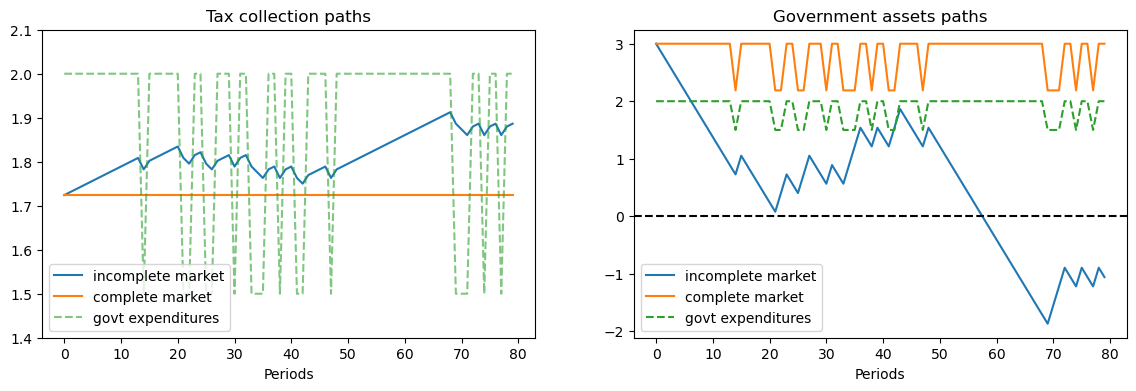

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].set_title('Tax collection paths')
ax[0].plot(np.arange(N_simul), c_path, label='incomplete market')
ax[0].plot(np.arange(N_simul), np.full(N_simul, c_bar), label='complete market')
ax[0].plot(np.arange(N_simul), y_path, label='govt expenditures', alpha=.6, ls='--')
ax[0].legend()
ax[0].set_xlabel('Periods')
ax[0].set_ylim([1.4, 2.1])

ax[1].set_title('Government assets paths')
ax[1].plot(np.arange(N_simul), debt_path, label='incomplete market')
ax[1].plot(np.arange(N_simul), debt_complete[s_path], label='complete market')
ax[1].plot(np.arange(N_simul), y_path, label='govt expenditures', ls='--')
ax[1].legend()
ax[1].axhline(0, color='k', ls='--')
ax[1].set_xlabel('Periods')

plt.show()

In [6]:
def ex_post_gross_return(b, cp):
    """
    calculate the ex post one-period gross return on the portfolio
    of government assets, given b and Q.
    """
    Q = cp.β * cp.P

    values = Q @ b

    n = len(b)
    R = np.zeros((n, n))

    for i in range(n):
        ind = cp.P[i, :] != 0
        R[i, ind] = b[ind] / values[i]

    return R

def cumulative_return(s_path, R):
    """
    compute cumulative return from holding 1 unit market portfolio
    of government bonds, given some simulated state path.
    """
    T = len(s_path)

    RT_path = np.empty(T)
    RT_path[0] = 1
    RT_path[1:] = np.cumprod([R[s_path[t], s_path[t+1]] for t in range(T-1)])

    return RT_path

In [7]:
# Parameters
β = .96

# change notation y to g in the tax-smoothing example
g = [1, 2]
b0 = 1
P = np.array([[.8, .2],
              [.4, .6]])

cp = ConsumptionProblem(β, g, b0, P)
Q = β * P

# change notation c_bar to T_bar in the tax-smoothing example
T_bar, b = consumption_complete(cp)
R = ex_post_gross_return(b, cp)
s_path = [0, 1, 1, 1, 0]
RT_path = cumulative_return(s_path, R)

print(f"P \n {P}")
print(f"Q \n {Q}")
print(f"Govt expenditures in peace and war = {g}")
print(f"Constant tax collections = {T_bar}")
print(f"Govt debts in two states = {-b}")

msg = """
Now let's check the government's budget constraint in peace and war.
Our assumptions imply that the government always purchases 0 units of the
Arrow peace security.
"""
print(msg)

AS1 = Q[0, :] @ b
# spending on Arrow security
# since the spending on Arrow peace security is not 0 anymore after we change b0 to 1
print(f"Spending on Arrow security in peace = {AS1}")
AS2 = Q[1, :] @ b
print(f"Spending on Arrow security in war = {AS2}")

print("")
# tax collections minus debt levels
print("Government tax collections minus debt levels in peace and war")
TB1 = T_bar + b[0]
print(f"T+b in peace = {TB1}")
TB2 = T_bar + b[1]
print(f"T+b in war = {TB2}")

print("")
print("Total government spending in peace and war")
G1 = g[0] + AS1
G2 = g[1] + AS2
print(f"Peace = {G1}")
print(f"War = {G2}")

print("")
print("Let's see ex-post and ex-ante returns on Arrow securities")

Π = np.reciprocal(Q)
exret = Π
print(f"Ex-post returns to purchase of Arrow securities = \n {exret}")
exant = Π * P
print(f"Ex-ante returns to purchase of Arrow securities \n {exant}")

print("")
print("The Ex-post one-period gross return on the portfolio of government assets")
print(R)

print("")
print("The cumulative return earned from holding 1 unit market portfolio of government bonds")
print(RT_path[-1])

P 
 [[0.8 0.2]
 [0.4 0.6]]
Q 
 [[0.768 0.192]
 [0.384 0.576]]
Govt expenditures in peace and war = [1, 2]
Constant tax collections = 1.2716883116883118
Govt debts in two states = [-1.         -2.62337662]

Now let's check the government's budget constraint in peace and war.
Our assumptions imply that the government always purchases 0 units of the
Arrow peace security.

Spending on Arrow security in peace = 1.2716883116883118
Spending on Arrow security in war = 1.895064935064935

Government tax collections minus debt levels in peace and war
T+b in peace = 2.2716883116883118
T+b in war = 3.895064935064935

Total government spending in peace and war
Peace = 2.2716883116883118
War = 3.895064935064935

Let's see ex-post and ex-ante returns on Arrow securities
Ex-post returns to purchase of Arrow securities = 
 [[1.30208333 5.20833333]
 [2.60416667 1.73611111]]
Ex-ante returns to purchase of Arrow securities 
 [[1.04166667 1.04166667]
 [1.04166667 1.04166667]]

The Ex-post one-period gross r

In [8]:
class TaxSmoothingExample:
    """
    construct a tax-smoothing example, by relabeling consumption problem class.
    """
    def __init__(self, g, P, b0, states, β=.96,
                 init=0, s_path=None, N_simul=80, random_state=1):

        self.states = states # state names

        # if the path of states is not specified
        if s_path is None:
            self.cp = ConsumptionProblem(β, g, b0, P, init=init)
            self.s_path = self.cp.simulate(N_simul=N_simul, random_state=random_state)
        # if the path of states is specified
        else:
            self.cp = ConsumptionProblem(β, g, b0, P, init=s_path[0])
            self.s_path = s_path

        # solve for complete market case
        self.T_bar, self.b = consumption_complete(self.cp)
        self.debt_value = - (β * P @ self.b).T

        # solve for incomplete market case
        self.T_path, self.asset_path, self.g_path = \
            consumption_incomplete(self.cp, self.s_path)

        # calculate returns on state-contingent debt
        self.R = ex_post_gross_return(self.b, self.cp)
        self.RT_path = cumulative_return(self.s_path, self.R)

    def display(self):

        # plot graphs
        N = len(self.T_path)

        plt.figure()
        plt.title('Tax collection paths')
        plt.plot(np.arange(N), self.T_path, label='incomplete market')
        plt.plot(np.arange(N), np.full(N, self.T_bar), label='complete market')
        plt.plot(np.arange(N), self.g_path, label='govt expenditures', alpha=.6, ls='--')
        plt.legend()
        plt.xlabel('Periods')
        plt.show()

        plt.title('Government debt paths')
        plt.plot(np.arange(N), -self.asset_path, label='incomplete market')
        plt.plot(np.arange(N), -self.b[self.s_path], label='complete market')
        plt.plot(np.arange(N), self.g_path, label='govt expenditures', ls='--')
        plt.plot(np.arange(N), self.debt_value[self.s_path], label="value of debts today")
        plt.legend()
        plt.axhline(0, color='k', ls='--')
        plt.xlabel('Periods')
        plt.show()

        fig, ax = plt.subplots()
        ax.set_title('Cumulative return path (complete markets)')
        line1 = ax.plot(np.arange(N), self.RT_path, color='blue')[0]
        c1 = line1.get_color()
        ax.set_xlabel('Periods')
        ax.set_ylabel('Cumulative return', color=c1)

        ax_ = ax.twinx()
        line2 = ax_.plot(np.arange(N), self.g_path, ls='--', color='green')[0]
        c2 = line2.get_color()
        ax_.set_ylabel('Government expenditures', color=c2)

        plt.show()

        # plot detailed information
        Q = self.cp.β * self.cp.P

        print(f"P \n {self.cp.P}")
        print(f"Q \n {Q}")
        print(f"Govt expenditures in {', '.join(self.states)} = {self.cp.y.flatten()}")
        print(f"Constant tax collections = {self.T_bar}")
        print(f"Govt debt in {len(self.states)} states = {-self.b}")

        print("")
        print(f"Government tax collections minus debt levels in {', '.join(self.states)}")
        for i in range(len(self.states)):
            TB = self.T_bar + self.b[i]
            print(f"  T+b in {self.states[i]} = {TB}")

        print("")
        print(f"Total government spending in {', '.join(self.states)}")
        for i in range(len(self.states)):
            G = self.cp.y[i, 0] + Q[i, :] @ self.b
            print(f"  {self.states[i]} = {G}")

        print("")
        print("Let's see ex-post and ex-ante returns on Arrow securities \n")

        print(f"Ex-post returns to purchase of Arrow securities:")
        for i in range(len(self.states)):
            for j in range(len(self.states)):
                if Q[i, j] != 0.:
                    print(f"  π({self.states[j]}|{self.states[i]}) = {1/Q[i, j]}")

        print("")
        exant = 1 / self.cp.β
        print(f"Ex-ante returns to purchase of Arrow securities = {exant}")

        print("")
        print("The Ex-post one-period gross return on the portfolio of government assets")
        print(self.R)

        print("")
        print("The cumulative return earned from holding 1 unit market portfolio of government bonds")
        print(self.RT_path[-1])

In [9]:
γ = .1
λ = .1
ϕ = .1
θ = .1
ψ = .1
g_L = .5
g_M = .8
g_H = 1.2
β = .96

In [10]:
g_ex1 = [g_L, g_H, g_M]
P_ex1 = np.array([[1-λ, λ,  0],
                  [0, 1-ϕ,  ϕ],
                  [0,   0,  1]])
b0_ex1 = 1
states_ex1 = ['peace', 'war', 'postwar']

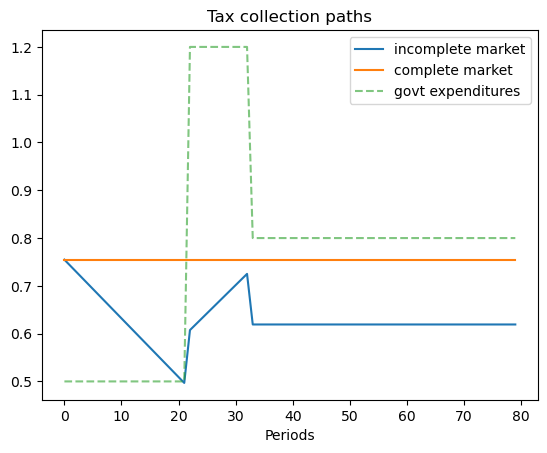

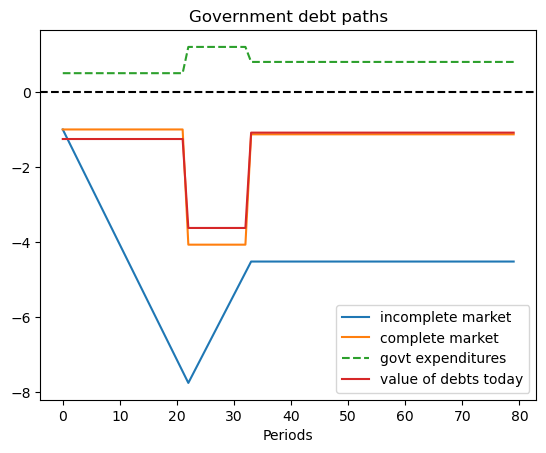

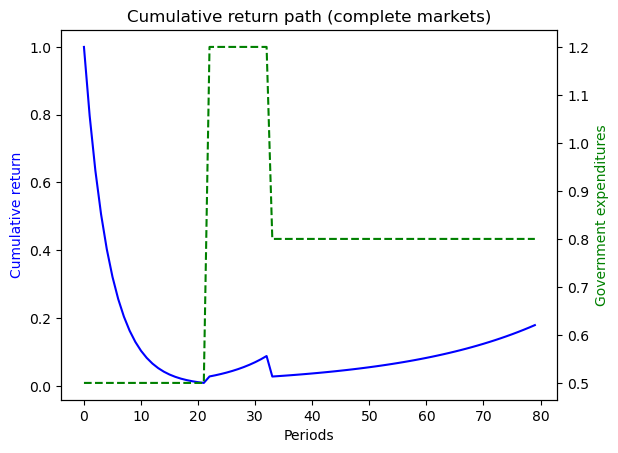

P 
 [[0.9 0.1 0. ]
 [0.  0.9 0.1]
 [0.  0.  1. ]]
Q 
 [[0.864 0.096 0.   ]
 [0.    0.864 0.096]
 [0.    0.    0.96 ]]
Govt expenditures in peace, war, postwar = [0.5 1.2 0.8]
Constant tax collections = 0.7548096885813148
Govt debt in 3 states = [-1.         -4.07093426 -1.12975779]

Government tax collections minus debt levels in peace, war, postwar
  T+b in peace = 1.754809688581315
  T+b in war = 4.825743944636677
  T+b in postwar = 1.8845674740484442

Total government spending in peace, war, postwar
  peace = 1.754809688581315
  war = 4.825743944636678
  postwar = 1.8845674740484442

Let's see ex-post and ex-ante returns on Arrow securities 

Ex-post returns to purchase of Arrow securities:
  π(peace|peace) = 1.1574074074074074
  π(war|peace) = 10.416666666666666
  π(war|war) = 1.1574074074074074
  π(postwar|war) = 10.416666666666666
  π(postwar|postwar) = 1.0416666666666667

Ex-ante returns to purchase of Arrow securities = 1.0416666666666667

The Ex-post one-period gross return on

In [11]:
ts_ex1 = TaxSmoothingExample(g_ex1, P_ex1, b0_ex1, states_ex1, random_state=1)
ts_ex1.display()

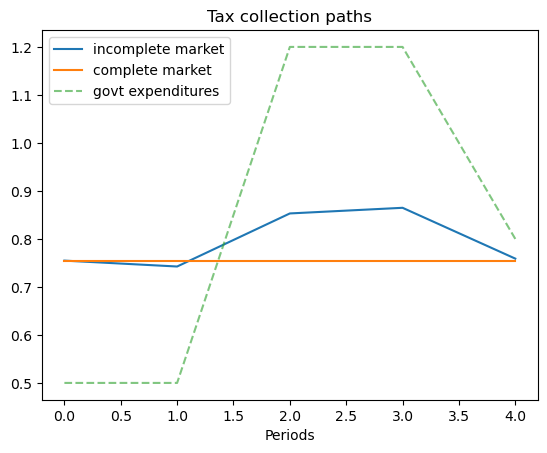

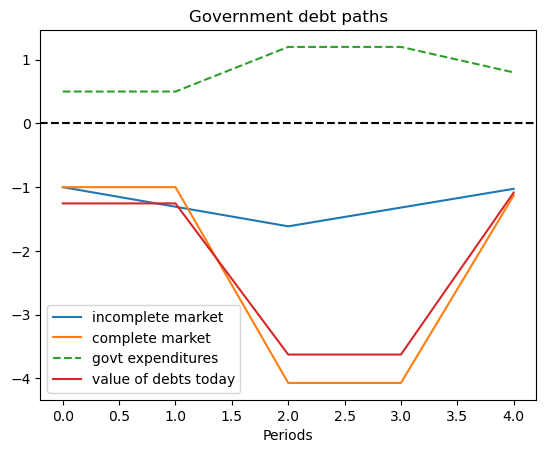

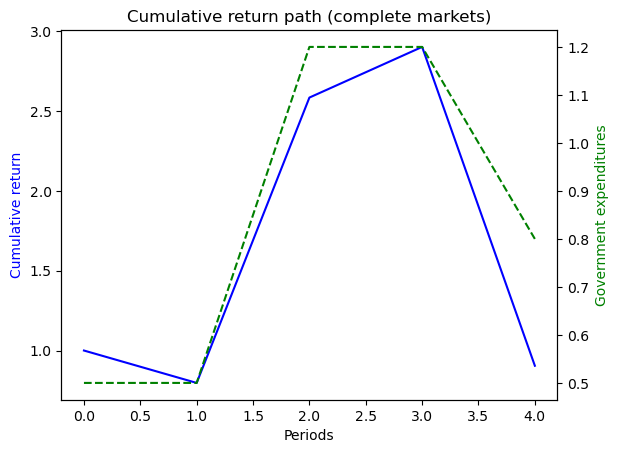

P 
 [[0.9 0.1 0. ]
 [0.  0.9 0.1]
 [0.  0.  1. ]]
Q 
 [[0.864 0.096 0.   ]
 [0.    0.864 0.096]
 [0.    0.    0.96 ]]
Govt expenditures in peace, war, postwar = [0.5 1.2 0.8]
Constant tax collections = 0.7548096885813148
Govt debt in 3 states = [-1.         -4.07093426 -1.12975779]

Government tax collections minus debt levels in peace, war, postwar
  T+b in peace = 1.754809688581315
  T+b in war = 4.825743944636677
  T+b in postwar = 1.8845674740484442

Total government spending in peace, war, postwar
  peace = 1.754809688581315
  war = 4.825743944636678
  postwar = 1.8845674740484442

Let's see ex-post and ex-ante returns on Arrow securities 

Ex-post returns to purchase of Arrow securities:
  π(peace|peace) = 1.1574074074074074
  π(war|peace) = 10.416666666666666
  π(war|war) = 1.1574074074074074
  π(postwar|war) = 10.416666666666666
  π(postwar|postwar) = 1.0416666666666667

Ex-ante returns to purchase of Arrow securities = 1.0416666666666667

The Ex-post one-period gross return on

In [12]:
# The following shows the use of the wrapper class when a specific state path is given
s_path = [0, 0, 1, 1, 2]
ts_s_path = TaxSmoothingExample(g_ex1, P_ex1, b0_ex1, states_ex1, s_path=s_path)
ts_s_path.display()

In [13]:
g_ex2 = [g_L, g_L, g_H]
P_ex2 = np.array([[1,   0,    0],
                  [0, 1-γ,    γ],
                  [ϕ,   0, 1-ϕ]])
b0_ex2 = 1
states_ex2 = ['peace', 'temporary peace', 'war']

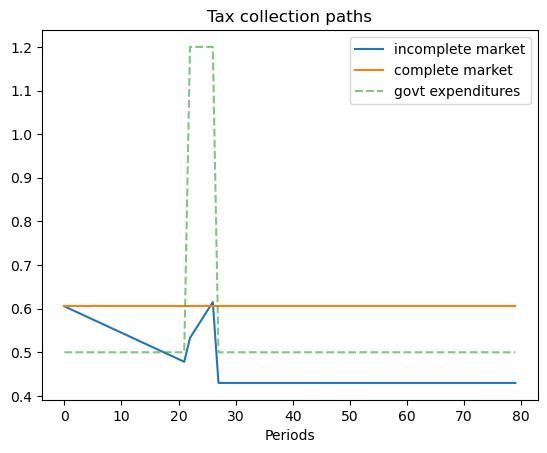

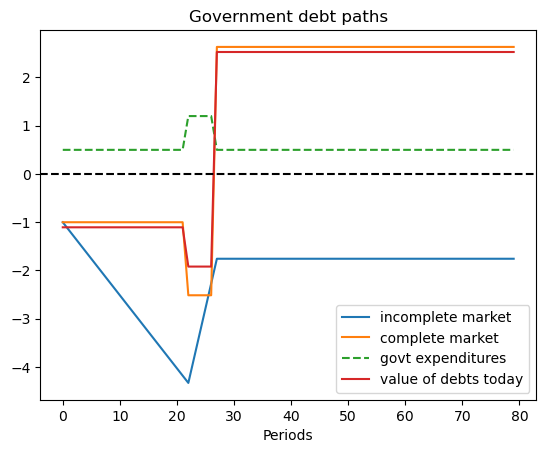

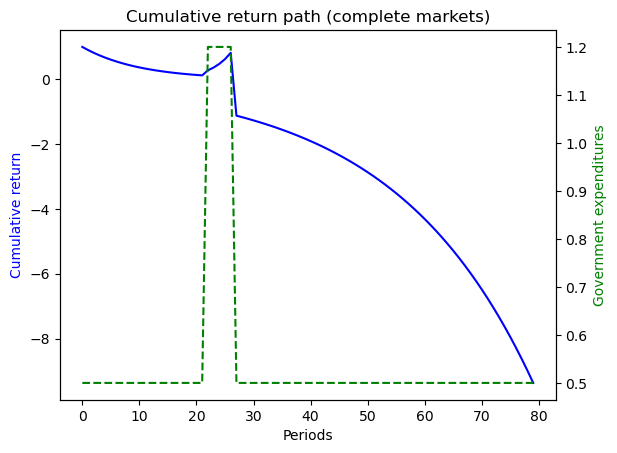

P 
 [[1.  0.  0. ]
 [0.  0.9 0.1]
 [0.1 0.  0.9]]
Q 
 [[0.96  0.    0.   ]
 [0.    0.864 0.096]
 [0.096 0.    0.864]]
Govt expenditures in peace, temporary peace, war = [0.5 0.5 1.2]
Constant tax collections = 0.6053287197231834
Govt debt in 3 states = [ 2.63321799 -1.         -2.51384083]

Government tax collections minus debt levels in peace, temporary peace, war
  T+b in peace = -2.027889273356398
  T+b in temporary peace = 1.6053287197231834
  T+b in war = 3.119169550173011

Total government spending in peace, temporary peace, war
  peace = -2.027889273356398
  temporary peace = 1.6053287197231834
  war = 3.1191695501730115

Let's see ex-post and ex-ante returns on Arrow securities 

Ex-post returns to purchase of Arrow securities:
  π(peace|peace) = 1.0416666666666667
  π(temporary peace|temporary peace) = 1.1574074074074074
  π(war|temporary peace) = 10.416666666666666
  π(peace|war) = 10.416666666666666
  π(war|war) = 1.1574074074074074

Ex-ante returns to purchase of Arrow secu

In [14]:
ts_ex2 = TaxSmoothingExample(g_ex2, P_ex2, b0_ex2, states_ex2, init=1, random_state=1)
ts_ex2.display()

In [15]:
g_ex3 = [g_L, g_L, g_H, g_H]
P_ex3 = np.array([[1-λ,  λ,   0,    0],
                  [0,  1-ϕ,   ϕ,     0],
                  [0,    0,  1-ψ,    ψ],
                  [θ,    0,    0,  1-θ ]])
b0_ex3 = 1
states_ex3 = ['peace1', 'peace2', 'war1', 'war2']

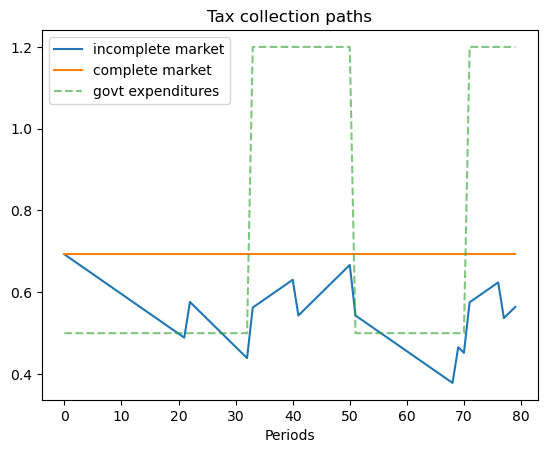

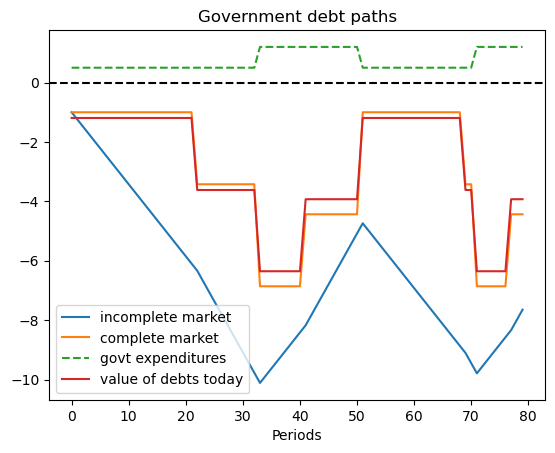

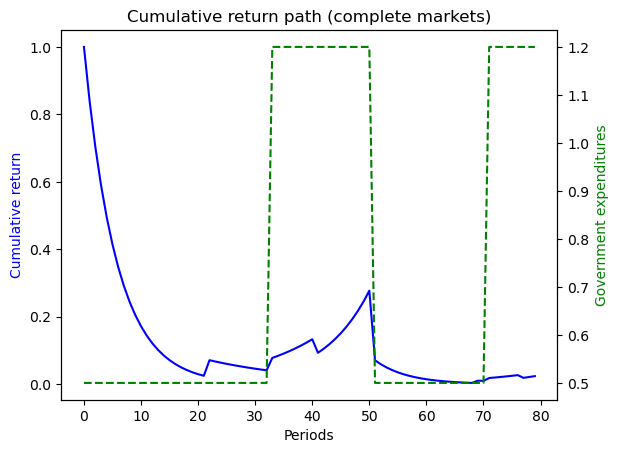

P 
 [[0.9 0.1 0.  0. ]
 [0.  0.9 0.1 0. ]
 [0.  0.  0.9 0.1]
 [0.1 0.  0.  0.9]]
Q 
 [[0.864 0.096 0.    0.   ]
 [0.    0.864 0.096 0.   ]
 [0.    0.    0.864 0.096]
 [0.096 0.    0.    0.864]]
Govt expenditures in peace1, peace2, war1, war2 = [0.5 0.5 1.2 1.2]
Constant tax collections = 0.6927944572748268
Govt debt in 4 states = [-1.         -3.42494226 -6.86027714 -4.43533487]

Government tax collections minus debt levels in peace1, peace2, war1, war2
  T+b in peace1 = 1.6927944572748268
  T+b in peace2 = 4.117736720554273
  T+b in war1 = 7.553071593533488
  T+b in war2 = 5.128129330254041

Total government spending in peace1, peace2, war1, war2
  peace1 = 1.6927944572748268
  peace2 = 4.117736720554273
  war1 = 7.553071593533487
  war2 = 5.128129330254041

Let's see ex-post and ex-ante returns on Arrow securities 

Ex-post returns to purchase of Arrow securities:
  π(peace1|peace1) = 1.1574074074074074
  π(peace2|peace1) = 10.416666666666666
  π(peace2|peace2) = 1.1574074074074074
 

In [16]:
ts_ex3 = TaxSmoothingExample(g_ex3, P_ex3, b0_ex3, states_ex3, random_state=1)
ts_ex3.display()

In [17]:
g_ex4 = [g_L, g_L, g_H, g_H, g_L]
P_ex4 = np.array([[1-λ,  λ,   0,     0,    0],
                  [0,  1-ϕ,   ϕ,     0,    0],
                  [0,    0,  1-ψ,    ψ,    0],
                  [0,    0,    0,   1-θ,   θ],
                  [0,    0,    0,     0,   1]])
b0_ex4 = 1
states_ex4 = ['peace1', 'peace2', 'war1', 'war2', 'permanent peace']

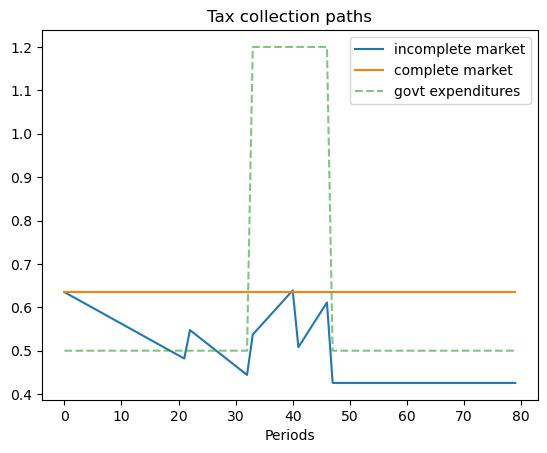

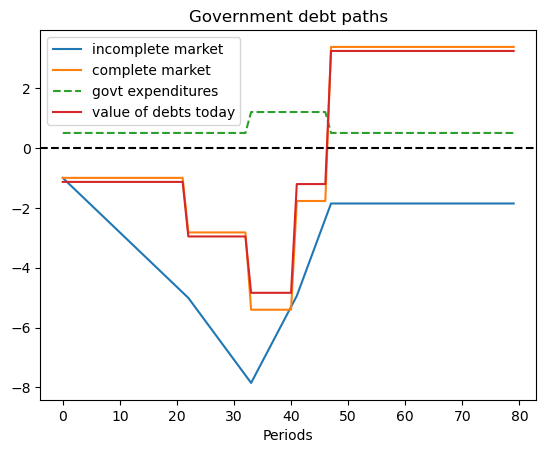

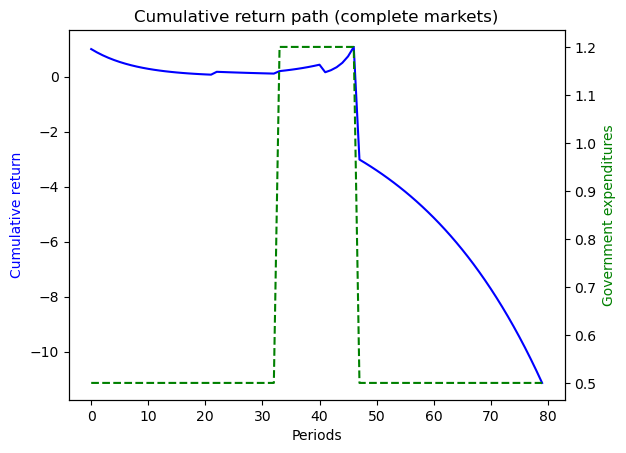

P 
 [[0.9 0.1 0.  0.  0. ]
 [0.  0.9 0.1 0.  0. ]
 [0.  0.  0.9 0.1 0. ]
 [0.  0.  0.  0.9 0.1]
 [0.  0.  0.  0.  1. ]]
Q 
 [[0.864 0.096 0.    0.    0.   ]
 [0.    0.864 0.096 0.    0.   ]
 [0.    0.    0.864 0.096 0.   ]
 [0.    0.    0.    0.864 0.096]
 [0.    0.    0.    0.    0.96 ]]
Govt expenditures in peace1, peace2, war1, war2, permanent peace = [0.5 0.5 1.2 1.2 0.5]
Constant tax collections = 0.6349979047185738
Govt debt in 5 states = [-1.         -2.82289484 -5.4053292  -1.77211121  3.37494762]

Government tax collections minus debt levels in peace1, peace2, war1, war2, permanent peace
  T+b in peace1 = 1.6349979047185736
  T+b in peace2 = 3.4578927455370514
  T+b in war1 = 6.040327103363227
  T+b in war2 = 2.407109110283644
  T+b in permanent peace = -2.739949713245768

Total government spending in peace1, peace2, war1, war2, permanent peace
  peace1 = 1.6349979047185739
  peace2 = 3.4578927455370514
  war1 = 6.040327103363227
  war2 = 2.4071091102836437
  permanent peace =

In [18]:
ts_ex4 = TaxSmoothingExample(g_ex4, P_ex4, b0_ex4, states_ex4, random_state=1)
ts_ex4.display()

In [19]:
g_ex5 = [g_L, g_L, g_H, g_H, g_H, g_H, g_L]
P_ex5 = np.array([[0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 0, 1],
                  [0, 0, 0, 0, 0, 0, 1]])
b0_ex5 = 1
states_ex5 = ['peace1', 'peace2', 'war1', 'war2', 'war3', 'permanent peace']

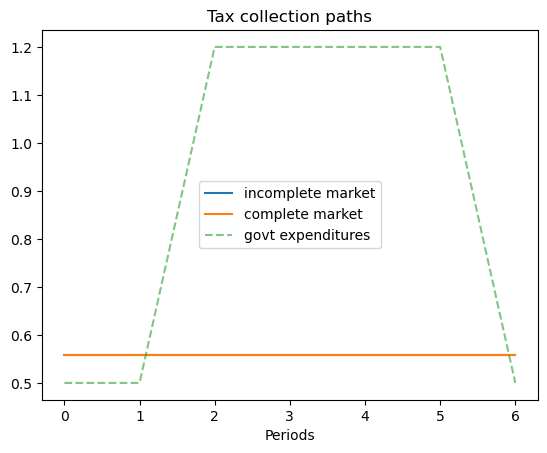

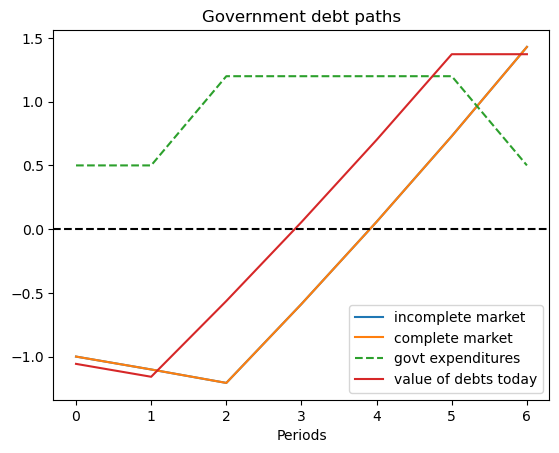

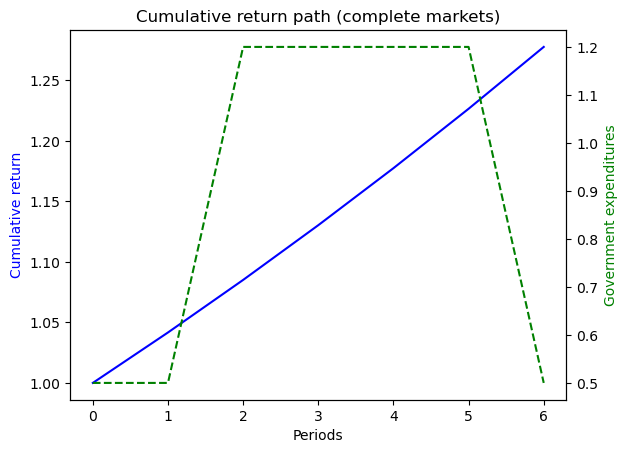

P 
 [[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]]
Q 
 [[0.   0.96 0.   0.   0.   0.   0.  ]
 [0.   0.   0.96 0.   0.   0.   0.  ]
 [0.   0.   0.   0.96 0.   0.   0.  ]
 [0.   0.   0.   0.   0.96 0.   0.  ]
 [0.   0.   0.   0.   0.   0.96 0.  ]
 [0.   0.   0.   0.   0.   0.   0.96]
 [0.   0.   0.   0.   0.   0.   0.96]]
Govt expenditures in peace1, peace2, war1, war2, war3, permanent peace = [0.5 0.5 1.2 1.2 1.2 1.2 0.5]
Constant tax collections = 0.5571895472128001
Govt debt in 6 states = [-1.         -1.10123911 -1.20669652 -0.58738132  0.05773868  0.72973868
  1.42973868]

Government tax collections minus debt levels in peace1, peace2, war1, war2, war3, permanent peace
  T+b in peace1 = 1.5571895472128001
  T+b in peace2 = 1.6584286588928003
  T+b in war1 = 1.7638860668928003
  T+b in war2 = 1.1445708668928005
  T+b in war3 = 0.4994508668928005
  T+b in permanent peace = -0.17254913310719944

Total government s

In [20]:
ts_ex5 = TaxSmoothingExample(g_ex5, P_ex5, b0_ex5, states_ex5, N_simul=7, random_state=1)
ts_ex5.display()